In [1]:
import numpy as np

import torch

from torch_geometric_temporal.dataset import MTMDatasetLoader

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from torch_geometric_temporal.nn.attention import AAGCN

from tqdm import tqdm

from torch_geometric_temporal.signal import temporal_signal_split

import torch.nn.functional as F

import os

import random

from torch.utils.tensorboard import SummaryWriter

%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [2]:
a=[]
for subdir, dirs, files in os.walk('./test_data'):
    a=files

In [3]:
len(a)

109

In [4]:
wordsz=len(a)
frames=24
classes=wordsz
batch = 32
numvids=30
tots = numvids*wordsz
datasize = tots-(tots%batch)
nodes = 61
pivot=20
channels=3
seed=4 # deprecated
epochs= 50
topn= 1
tframes = 1

In [5]:
# Initialize dataset

alltensor=torch.zeros(wordsz*numvids, channels, frames, nodes)
targets=torch.zeros(wordsz*numvids,tframes,wordsz)
# interleaving words into alltensor
for i in range(wordsz):
    t=torch.load("./test_data/"+a[i])
    temp=[0]*wordsz
    temp[i]=1
    temp=[temp]*tframes
    temp=torch.tensor(temp)
    alltensor[i::wordsz] = t
    targets[i::wordsz] = temp
newx=alltensor
newy=targets

#load edge index tensor
our_edge_index=torch.load("cool_shit/new_edge_index.pt")

#load dataset
loader = MTMDatasetLoader()
dataset = loader.get_dataset()

#set edge index
dataset.edge_index = our_edge_index.long()

#loss
crLoss = torch.nn.CrossEntropyLoss()
nllLoss = torch.nn.NLLLoss()

In [6]:
class CoolGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(CoolGCN, self).__init__()
        self.r1 = AAGCN(3,32, torch.LongTensor(dataset.edge_index), node_features)
        self.r2 = AAGCN(32, 32,  torch.LongTensor(dataset.edge_index), node_features)
        self.r3 = AAGCN(32, 64,  torch.LongTensor(dataset.edge_index), node_features,stride =2)
        self.r4 = AAGCN(64, 64,  torch.LongTensor(dataset.edge_index), node_features)
        self.r5 = AAGCN(64, 128,  torch.LongTensor(dataset.edge_index), node_features,stride = 2)
        self.r6 = AAGCN(128, 128,  torch.LongTensor(dataset.edge_index), node_features)
        self.r7 = AAGCN(128, 256,  torch.LongTensor(dataset.edge_index), node_features,stride = 2)
        self.r8 = AAGCN(256, 256,  torch.LongTensor(dataset.edge_index), node_features)
        self.r9 = AAGCN(256, 768,  torch.LongTensor(dataset.edge_index), node_features,stride = 3)
        self.r10 = AAGCN(768, 768,  torch.LongTensor(dataset.edge_index), node_features)
        self.linear = torch.nn.Linear(nodes, classes)
        self.dropout = torch.nn.Dropout(0.4)
    def forward(self, x):
        h = self.r1(x)
        h = self.r2(h)
        h = self.r3(h)
        h = self.r4(h)
        h = self.r5(h)
        h = self.r6(h)
        h = self.r7(h)
        h = self.r8(h)
        h = self.r9(h)
        h = self.r10(h)
        h = h.mean(1)
        h = self.dropout(h)
        h = self.linear(h)
        return h

In [7]:
#check cuda availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#load model to device
model = CoolGCN(node_features = nodes).to(device)
#load model from file
# model.load_state_dict(torch.load("model10L32B31W5P.pth"))

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
#newx and newy shape manipulation
newx = torch.reshape(newx[:datasize],(datasize//batch,batch,channels,frames,nodes))
dataset.newx = newx
dataset.newy = newy
dataset.newy = torch.reshape(torch.FloatTensor(dataset.newy[:datasize]), (datasize//batch,batch,tframes,classes))
dataset.newy.shape
dataset.newx.shape
dataset.newx=dataset.newx.cuda()
dataset.newy=dataset.newy.cuda()

#class labels list
labels=[x[:-3] for x in a]

In [8]:
# %%capture
model.train()
writer = SummaryWriter(f'runs/10layergcn/tensorboard_test')
writer.add_graph(model)
train=len(newx[pivot:])
eph=0
for epoch in tqdm(range(epochs)):
    for i in range(pivot,pivot+train):
        y_hat = model(dataset.newx[i])
        cost = crLoss(y_hat.reshape(batch*1,classes), torch.argmax(dataset.newy[i].reshape(batch*tframes,classes), dim = 1))
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
    count = 0
    total = 0
    train=len(newx[:pivot])
    y_model=torch.zeros(pivot*batch)
    y_truth=torch.zeros(pivot*batch)
    with torch.no_grad():
        for i in range(pivot):
            y_hat = model(dataset.newx[i])
            y_act = dataset.newy[i]
            for j in range(batch):
                predval=y_hat[j]
                trueval=y_act[j]
                framepreds=torch.zeros(24)
                frametrues=torch.zeros(24)
                for k in range(frames):
                    framepreds[k]=torch.argmax(predval[k])
                    frametrues[k]=torch.argmax(trueval[k])
                y_model[total]=torch.mode(framepreds).values
                y_truth[total]=truemode=torch.mode(frametrues).values
                if y_model[total]==y_truth[total]:
                    count+=1
                total+=1
    writer.add_scalar('accuracy', count/total,global_step=eph)
    cm = confusion_matrix(y_true=y_truth, y_pred=y_model)
    fig, ax = plt.subplots(figsize=(22,22))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, colorbar=False)
    writer.add_figure("confusion matrix", fig, global_step=eph)
    eph+=1

# save model
# FILE = "model10L32B15W3P.pth"
# torch.save(model.state_dict(), FILE)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:45<00:00,  5.71s/it]


In [9]:
#save model
FILE = "./models/model10L32B28W_withstrides.pth"
torch.save(model.state_dict(), FILE)

# Load model

In [10]:
model.load_state_dict(torch.load("./models/fulledgemodel.pth"))

<All keys matched successfully>

# EVAL

In [11]:
model.eval()
count = 0
total = 0
lenall = pivot
train=len(newx[:pivot])
y_model=torch.zeros(lenall*batch)
y_truth=torch.zeros(lenall*batch)
top5=torch.zeros(topn)
with torch.no_grad():
    for i in range(lenall):
        y_hat = model(dataset.newx[i])
        y_act = dataset.newy[i]
        for j in range(batch):
            predval=y_hat[j]
            trueval=y_act[j]
            framepreds=torch.zeros(tframes)
            frametrues=torch.zeros(tframes)
            
            top5=torch.topk(predval[0],topn)
            ftrue=torch.argmax(trueval[0])
            frametrues[0]=ftrue
            if ftrue in top5.indices:
                framepreds[0] = ftrue
                count+=1
            else:
                framepreds[0] = top5.indices[0]
            
            y_model[total]=torch.mode(framepreds).values
            y_truth[total]=torch.mode(frametrues).values
#             if y_model[total]==y_truth[total]:
#                 count+=1
            total+=1
print("Acc : ",round(count/total*100, 2)," | tot batches : ",len(newx)," | test : ",pivot," | train : ",len(newx)-pivot," | BS : ",batch)

Acc :  83.75  | tot batches :  102  | test :  20  | train :  82  | BS :  32


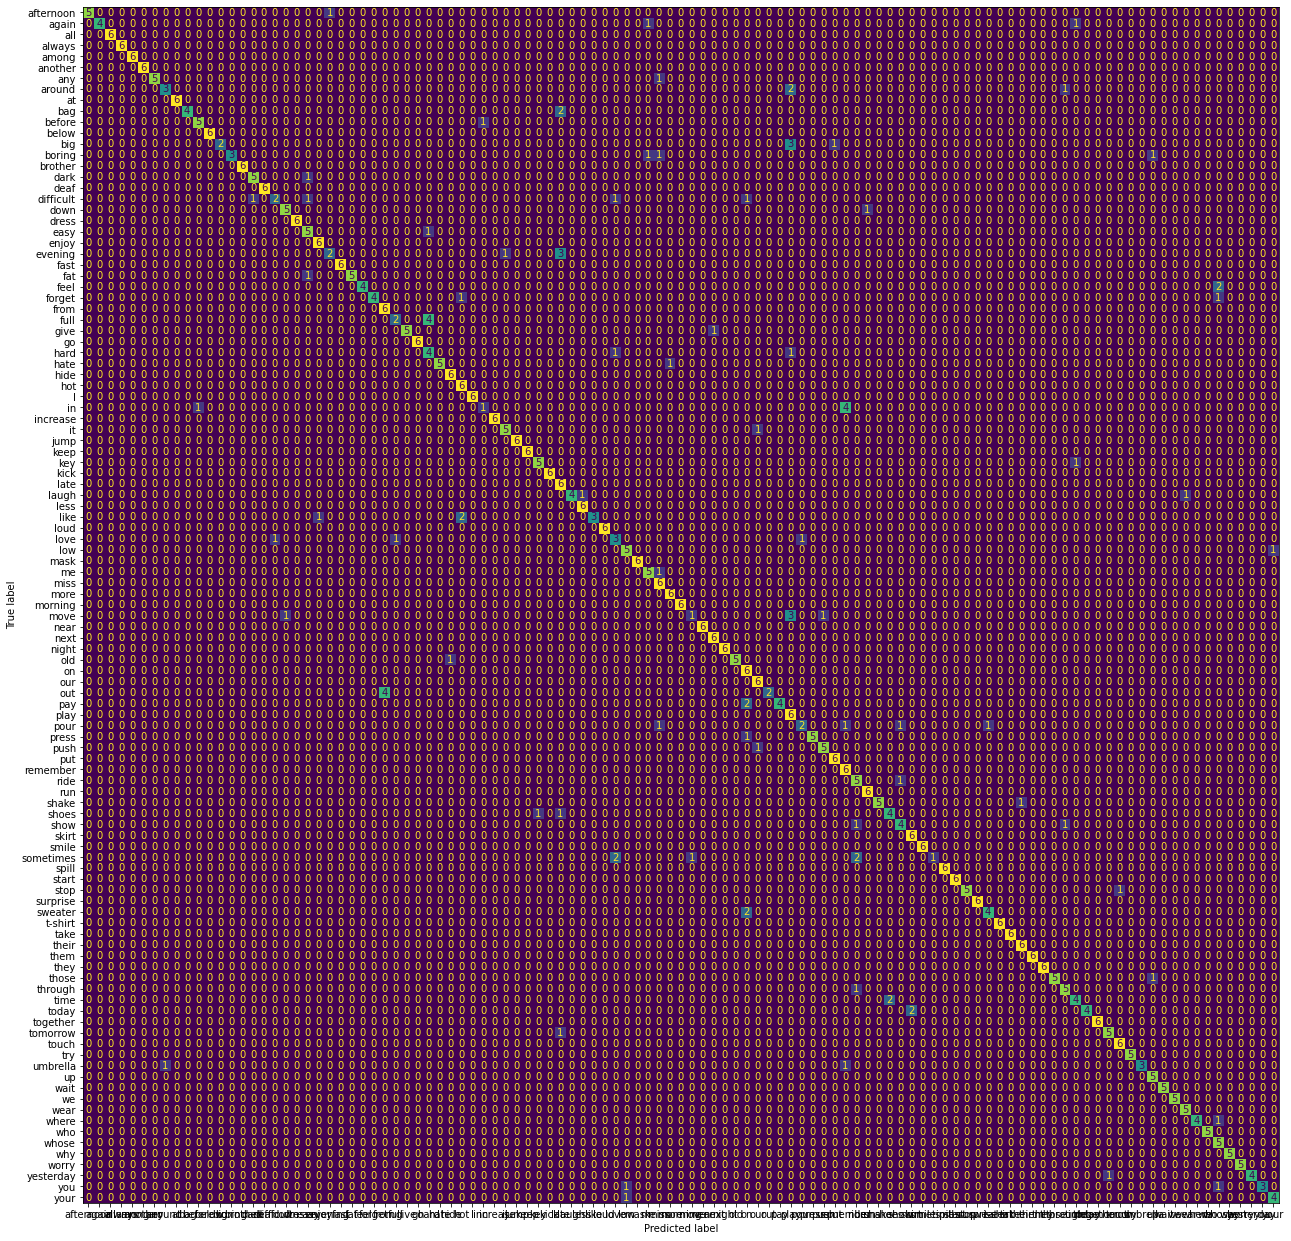

In [23]:
cm = confusion_matrix(y_true=y_truth, y_pred=y_model)
fig, ax = plt.subplots(figsize=(22,22))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(ax=ax, colorbar=False)